---
# Group statistics of pRF overlap

The main difference with the `group_overlap.ipynb` is that the neighbouring vertices originate from the whole-brain fit; not for every run (saves clogging up of the figure). Additionally, I aim to average across the iterations of the pRF experiment, see if that boosts statistics while retaining the original results

In [12]:
%matplotlib inline

In [2]:
from linescanning import (
    utils,
    plotting,
    prf,
    dataset,
    glm,
    optimal,
    fitting
)

from datetime import datetime
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy import io, stats
import pandas as pd
import pRFline
from pRFline.plotting import pRFSpread
from pRFline.utils import SubjectsDict, sort_posthoc
import pingouin
import seaborn as sns
opj = os.path.join
opd = os.path.dirname

scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


230112-09:41:16,638 nipype.utils WARNING:
	 A newer version (1.8.4) of nipy/nipype is available. You are using 1.8.2


In [3]:
# set defaults
task        = "task-pRF"
base_dir    = "/data1/projects/MicroFunc/Jurjen/projects/VE-pRF"
prog_dir    = "/data1/projects/MicroFunc/Jurjen/programs/project_repos/pRFline"
design_dir  = opj(prog_dir, "data_lp3")
fig_dir     = opj(prog_dir, "results")

if "_lp" in os.path.basename(design_dir):
    filter_strat = "lp"
    w_length = 11
    p_order = 3 
else:
    filter_strat = "hp"
    w_length = None
    p_order = None

In [4]:
verbose = False
fix_bold = True
model = "gauss"
fit_nbr = True
downsample = False
nbr_r2_thresh = 0.1

# fetch subject dictionary from pRFline.utils.SubjectsDict
subj_obj = SubjectsDict()
dict_data = subj_obj.dict_data


## Main data parser

Same loop as `overlap.py`, but because everything is run already, it just reads in the existing files

In [5]:
full_dict = {}

process_subjs = list(dict_data.keys())
# process_subjs = ["sub-001", "sub-002", "sub-003","sub-007","sub-008"]
# process_subjs = ["sub-009"] #, "sub-002", "sub-005"]

for subject in process_subjs:
    
    # get subject-specific session ID; sub-005 has multiple sessions, of which ses-2 was bad
    ses = subj_obj.get_session(subject)

    # define output directory
    data_output = opj(design_dir, subject)
    
    # initiate dictionary
    full_dict[subject] = {}

    print("\n---------------------------------------------------------------------------------------------------")
    print(f"Dealing with {subject} [{datetime.now().strftime('%Y/%m/%d %H:%M:%S')}]")
    print("\n-- linescanning --")

    # add line-scanning key
    full_dict[subject]["lines"] = {}

    ####################################################################################################
    # LINE-SCANNING BIT
    ####################################################################################################

    #---------------------------------------------------------------------------------------------------
    # get directories
    func_dir    = opj(base_dir, subject, f"ses-{ses}", "func")
    anat_dir    = opj(os.path.dirname(func_dir), 'anat')

    run_files   = utils.get_file_from_substring(
        [subject, f"ses-{ses}", f"{task}"], 
        func_dir, 
        exclude=dict_data[subject]["exclude"])
        
    func_file = utils.get_file_from_substring("bold.mat", run_files)
    anat_slices = utils.get_file_from_substring([subject, f"ses-{ses}", "acq-1slice", ".nii.gz"], anat_dir)
    ref_slices  = utils.match_lists_on(func_file, anat_slices, matcher='run')

    # mind you, the segmentations live in ses-1 space, NOT FREESURFER!
    ses_to_motion = utils.get_file_from_substring(f"ses{ses}_rec-motion1", opj(base_dir, "derivatives", 'pycortex', subject, 'transforms'))
    run2run = utils.get_file_from_substring(['.txt'], anat_dir)

    #---------------------------------------------------------------------------------------------------
    # PREPROCESSING

    print("Reading in data")
    data_obj = dataset.Dataset(
        func_file,
        use_bids=True,
        verbose=verbose,
        acompcor=True,
        ref_slice=ref_slices,
        ses1_2_ls=ses_to_motion,
        run_2_run=run2run,
        n_pca=5,
        filter_strategy=filter_strat,
        window_length=w_length,
        poly_order=p_order,
        deleted_last_timepoints=300,
        report=False)

    df_func = data_obj.fetch_fmri()

    # select ribbon voxels
    df_ribbon = utils.select_from_df(
        df_func, 
        expression="ribbon", 
        indices=dict_data[subject]["ribbon"])

    # average runs
    avg_psc = df_ribbon.groupby(['subject', "t"]).mean().values.mean(axis=-1)[np.newaxis,:]

    process_data = ["native"]
    if downsample:
        process_data += ["ds"]

    for res in process_data:

        print(f"Dealing with '{res}' as temporal resolution")
        full_dict[subject]["lines"][res] = {}

        # get low-res design 
        dm_f = opj(data_output, f"{subject}_acq-lines_res-{res}_desc-full_design.mat")
        if os.path.exists(dm_f):
            print(f" Reading {dm_f}")
            dm_ = prf.read_par_file(dm_f) 
        else:
            raise FileNotFoundError(f"Could not find file '{dm_f}'")              

        input_data = avg_psc.copy()
        tr = 0.105
        if res == "ds":
            tr = 1.5
            new_vols = int((avg_psc.shape[-1]*0.105)/tr)
            input_data = glm.resample_stim_vector(avg_psc.T, new_vols).T

        # sync design matrix and data shapes
        sync_dm = dm_[...,:input_data.shape[-1]]     

        avg_l = prf.pRFmodelFitting(
            input_data,
            design_matrix=sync_dm,
            model=model,
            TR=tr,
            fix_bold_baseline=fix_bold,
            verbose=verbose,
            rsq_threshold=0,
            screen_distance_cm=196,
            grid_nr=40,
            write_files=True,
            save_grid=False,
            output_dir=data_output,
            output_base=f"{subject}_acq-lines_res-{res}_vox-avg"
        )

        pars_file = opj(avg_l.output_dir, f"{avg_l.output_base}_model-{model}_stage-iter_desc-prf_params.pkl")
        if not os.path.exists(pars_file):
            print(f" Fitting {res} avg ribbon")
            print(f"  TR = {tr}; ")
            print(f"  data shape = {input_data.shape}")
            print(f"  design shape = {sync_dm.shape}")
            avg_l.fit()    
        else:
            print(f" Reading {pars_file}")
            avg_l.load_params(
                pars_file, 
                model=model, 
                stage="iter")

        full_dict[subject]["lines"][res] = {}
        full_dict[subject]["lines"][res]["avg"] = avg_l

        # fit across laminae
        input_data = df_ribbon.groupby(['subject', "t"]).mean().values

        vox_ = prf.pRFmodelFitting(
            input_data.T,
            design_matrix=sync_dm,
            model=model,
            TR=tr,
            fix_bold_baseline=fix_bold,
            verbose=verbose,
            rsq_threshold=0,
            screen_distance_cm=196,
            grid_nr=40,
            write_files=True,
            save_grid=False,
            output_dir=data_output,
            output_base=f"{subject}_acq-lines_res-{res}_vox-ribbon",
            old_params=getattr(avg_l, f"{model}_iter"),
            fix_parameters=[0,1],
            fit_hrf=True
        )

        pars_file = opj(vox_.output_dir, f"{vox_.output_base}_model-{model}_stage-iter_desc-prf_params.pkl")
        if not os.path.exists(pars_file):
            print(f" Fitting {res}-ribbon", flush=True)
            print(f"  data shape = {input_data.shape}", flush=True)
            print(f"  design shape = {sync_dm.shape}", flush=True)
            # vox_.fit()
        else:
            print(f" Reading {pars_file}", flush=True)
            vox_.load_params(
                pars_file, 
                model=model, 
                stage="iter")

        full_dict[subject]["lines"][res]["ribbon"] = vox_

    print("Done", flush=True)

    ####################################################################################################
    # 2D-EPI WHOLE-BRAIN BIT
    ####################################################################################################

    print("\n-- whole brain 2D-EPI --")
    
    # add whole-brain key
    full_dict[subject]["wb"] = {}
    full_dict[subject]["vertices"] = {}
    full_dict[subject]["vertices"]["target"] = subj_obj.get_target(subject)
    
    # fetch the neighbouring vertices
    nbr_obj = optimal.Neighbours(
        subject=subject,
        hemi="lh",
        verbose=True
    )

    nbr_obj.distances_to_target(target_vert=subj_obj.get_target(subject), hemi="lh")
    fit_verts = nbr_obj.lh_dist_to_targ_df.copy()

    print(f"Fitting {fit_verts.shape[0]-1} neighbouring vertices + target vertex {subj_obj.get_target(subject)}", flush=True)
        
    full_dict[subject]["vertices"]["all"] = fit_verts

    # get directories
    data_dir = opj(base_dir, "derivatives", "pybest", subject, "ses-1", "unzscored")
    data_files = utils.get_file_from_substring(["hemi-L","npy"], data_dir)
    design = utils.resample2d(prf.read_par_file(opj(base_dir, "derivatives", "prf", subject, "ses-1", "design_task-2R.mat")), new_size=100)

    # remove first 4 volumes
    cut_vols = 4
    design_cut = design.copy()[...,cut_vols:]

    collect_vox = []
    for ix,data in enumerate(data_files):

        full_dict[subject]["wb"][ix] = {}
        
        # get target vertex data
        vox_data = np.load(data)[cut_vols:,:]

        # convert to percent change
        vox_psc = utils.percent_change(vox_data, 0, baseline=15)

        # append
        collect_vox.append(vox_psc[...,np.newaxis])

    # concatenate <time,vertices,runs>
    collect_vox = np.concatenate(collect_vox, axis=-1)

    # fit average
    runs_epi = prf.pRFmodelFitting(
        collect_vox[:,subj_obj.get_target(subject),:].T,
        design_matrix=design_cut,
        fix_bold_baseline=fix_bold,
        model=model,
        verbose=verbose,
        rsq_threshold=0.05,
        TR=1.5,
        screen_distance_cm=210,
        screen_size_cm=dict_data[subject]["screen_size"],
        write_files=True,
        save_grid=False,
        output_dir=data_output,
        output_base=f"{subject}_acq-2DEPI_run-all",
        nr_jobs=1
    )

    pars_file = opj(runs_epi.output_dir, f"{runs_epi.output_base}_model-{model}_stage-iter_desc-prf_params.pkl")
    if not os.path.exists(pars_file):
        print(f"Fitting all runs [data={runs_epi.data.shape}]..", flush=True)
        runs_epi.fit()
    else:
        print(f"Reading all runs..", flush=True)
        runs_epi.load_params(
            pars_file, 
            model=model, 
            stage="iter")

    full_dict[subject]["wb"]['runs'] = runs_epi

    # collect avg whole brain pRF estimates
    avg = np.median(collect_vox, axis=-1)
    avg_epi = prf.pRFmodelFitting(
        avg.T,
        design_matrix=design_cut,
        model=model,
        verbose=verbose,
        TR=1.5,
        screen_distance_cm=210
    )

    pars_file = opj(
        base_dir,
        "derivatives",
        "prf",
        subject,
        "ses-1",
        f"{subject}_ses-1_task-2R_roi-V1_model-{model}_stage-iter_desc-prf_params.pkl"
    )
    
    if not os.path.exists(pars_file):
        raise FileNotFoundError(f"Could not find file '{pars_file}'. Run 'master -m 17' with '--v1' and '--norm'")
    else:
        print(f"Reading average EPI..", flush=True)
        avg_epi.load_params(
            pars_file, 
            model=model, 
            stage="iter")

    full_dict[subject]["wb"]['avg'] = avg_epi

    print("Done", flush=True)


---------------------------------------------------------------------------------------------------
Dealing with sub-001 [2023/01/12 09:41:24]

-- linescanning --
Reading in data
Dealing with 'native' as temporal resolution
 Reading /data1/projects/MicroFunc/Jurjen/programs/project_repos/pRFline/data_lp3/sub-001/sub-001_acq-lines_res-native_desc-full_design.mat
 Reading /data1/projects/MicroFunc/Jurjen/programs/project_repos/pRFline/data_lp3/sub-001/sub-001_acq-lines_res-native_vox-avg_model-gauss_stage-iter_desc-prf_params.pkl
 Reading /data1/projects/MicroFunc/Jurjen/programs/project_repos/pRFline/data_lp3/sub-001/sub-001_acq-lines_res-native_vox-ribbon_model-gauss_stage-iter_desc-prf_params.pkl
Done

-- whole brain 2D-EPI --
Initializing SurfaceCalc
Creating subsurfaces for V1_exvivo.thresh
Target vertex '1053' is at index '336' in subsurface
Finding distances from V1_exvivo.thresh to vertex #336
Fitting 4890 neighbouring vertices + target vertex 1053
Reading all runs..
Reading ave

## Main summary plot

Contains:

- row of subject-specific plots in visual space with the EPI-runs (grey circles), average EPI (black circle) and the average line pRF across the ribbon (subject-specific color)
- plot of normalized pRFs for all subjects
- r2 for various flavours (e.g., average EPI, EPI-runs, average line)
- Distance to average EPI (from EPI runs, 2mm away, 4mm away, 6mm away and the average line pRF)

In [6]:
colors=["#DE3163", "#6495ED"]
cmap1 = utils.make_binary_cm(colors[0])

subjects = list(dict_data.keys())
cmap_subj = "Set2"
sub_colors = sns.color_palette(cmap_subj, len(subjects))

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [7]:
# figure settings
fig = plt.figure(figsize=(24,10))
subfigs = fig.subfigures(nrows=2, height_ratios=[0.5,1])
axs_subj = subfigs[0].subplots(ncols=len(dict_data))
axs_avg = subfigs[1].subplots(
    ncols=3, 
    gridspec_kw={
        'width_ratios': [0.5,0.2,0.5], 
        'wspace': 0.3})

sub-001: target=336 | geodesic distance=0.0 | functional distance=0.0
sub-002: target=548 | geodesic distance=0.0 | functional distance=0.0
sub-003: target=345 | geodesic distance=0.0 | functional distance=0.0
sub-005: target=1158 | geodesic distance=0.0 | functional distance=0.0
sub-007: target=686 | geodesic distance=0.0 | functional distance=0.0
sub-008: target=2005 | geodesic distance=0.0 | functional distance=0.0
sub-009: target=619 | geodesic distance=0.0 | functional distance=0.0


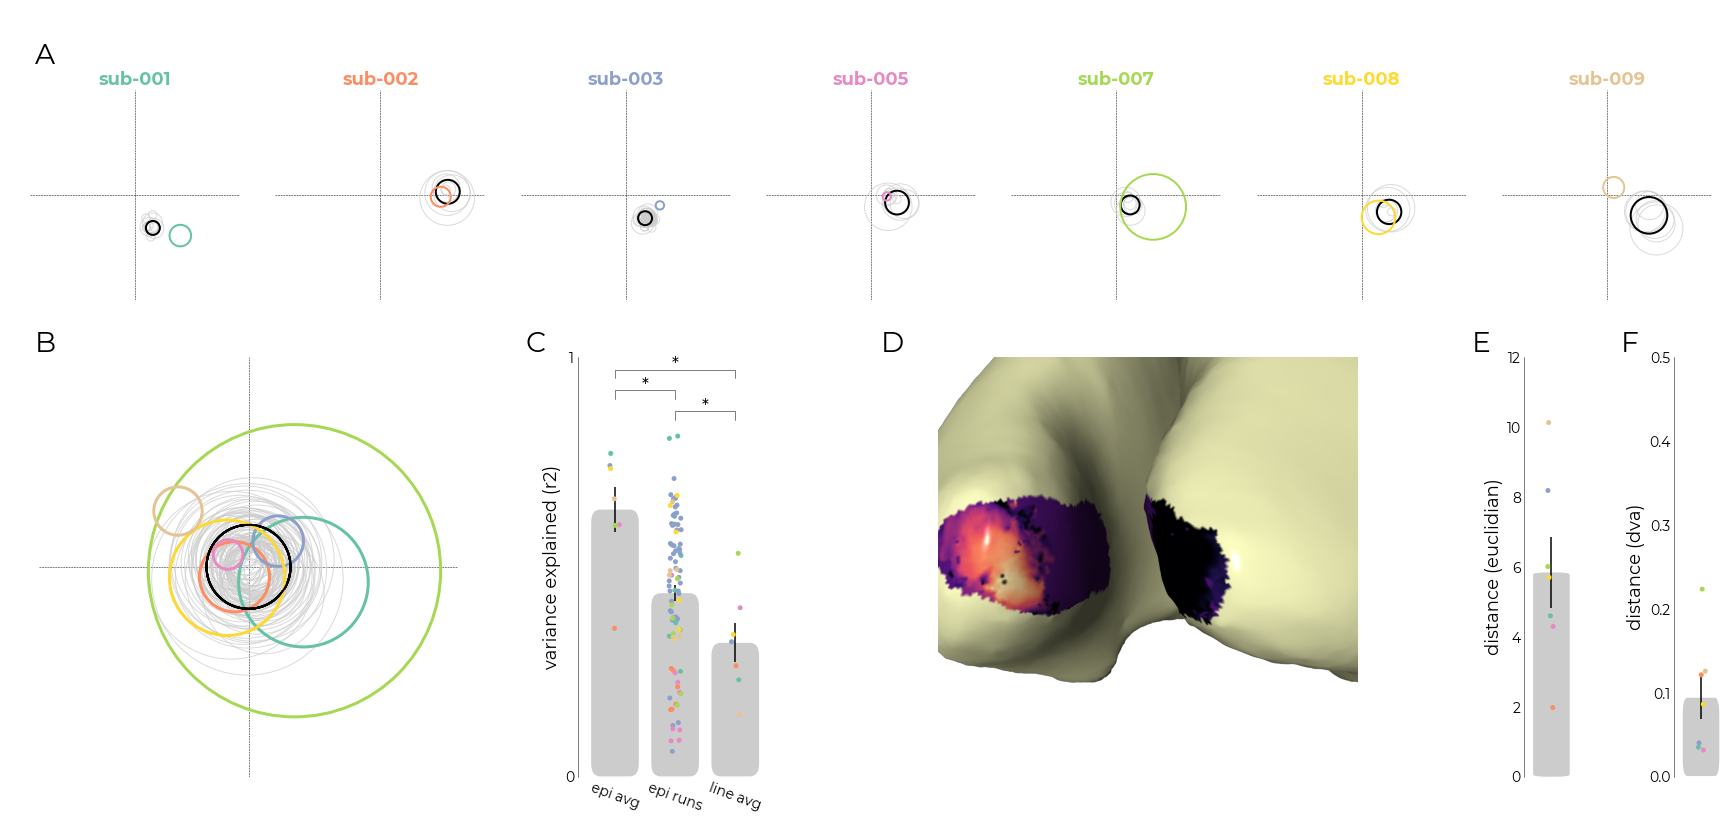

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,cohen,distances
0,name,epi avg,epi runs,False,True,3.489167,7.575078,two-sided,0.008944,0.013417,fdr_bh,35.21,1.119822,1
1,name,epi avg,line avg,False,True,4.440721,12.000000,two-sided,0.000806,0.002418,fdr_bh,34.111,2.373665,2
2,name,epi runs,line avg,False,True,2.331982,8.099691,two-sided,0.047633,0.047633,fdr_bh,2.721,0.667865,1


In [13]:
# figure settings
fig = plt.figure(figsize=(24,10))
subfigs = fig.subfigures(nrows=2, height_ratios=[0.5,1])
axs_subj = subfigs[0].subplots(ncols=len(dict_data))
axs_avg = subfigs[1].subplots(
    ncols=5, 
    gridspec_kw={
        'width_ratios': [0.5,0.2,0.6,0.05,0.05], 
        'wspace': 0.4})

# axis for pRF overlap plot
axs = axs_avg[0]

r2s, dist, geod = {},{},{}
r2s["subject"], r2s["r2"], r2s["acq"], r2s["name"] = [],[],[],[]
geod["subject"], geod["d_prf"], geod["d_mm"] = [],[],[]

# if fit_nbr == True, target vertex is last row
est_idx = 0

for ix,sub in enumerate(process_subjs):

    ax_ = axs_subj[ix]
        
    # find index of target 
    est_idx = np.where(np.array(full_dict[sub]["vertices"]["all"]) == subj_obj.get_target(sub))[0][0]

    run_obj = full_dict[sub]['wb']['runs']
    avg_obj = full_dict[sub]['wb']['avg']
    for run in range(run_obj.data.shape[0]):
        # get parameters from individual runs 
        pars,_,_,_ = run_obj.plot_vox(
            vox_nr=run,
            model=model,
            stage='iter',
            make_figure=False
        )

        if pars[-1] != 0:
            # get parameters from average
            avg_pars,_,_,_ = avg_obj.plot_vox(
                vox_nr=subj_obj.get_target(sub),
                model=model,
                stage='iter',
                make_figure=False
            )

            # append r2 to dictionary
            r2s["r2"].append(pars[-1])
            r2s["subject"].append(sub)
            r2s["name"].append("epi runs")
            r2s["acq"].append(1)

            # plot normalized pRF
            run_norm = prf.normalize_prf(avg_pars,pars)
            
            # find x/y of max pRF
            center = (run_norm[0],run_norm[1])
            circ2 = plt.Circle(
                center,
                run_norm[2],
                ec="#cccccc",
                fill=False,
                alpha=0.7)
        
            axs.add_artist(circ2)

            # add non-normalized to subject specific axis
            circ_run_subj = plt.Circle(
                (pars[0],pars[1]),
                pars[2],
                ec="#cccccc",
                fill=False,
                alpha=0.7)

            ax_.add_artist(circ_run_subj)            
            
    else:
        r2s["r2"].append(getattr(avg_obj, f"{model}_iter")[subj_obj.get_target(sub),-1])
        r2s["subject"].append(sub)
        r2s["name"].append("epi avg")
        r2s["acq"].append(0)

        # only get the distance of neighbouring vertices in EPI average
        df_v1 = full_dict[sub]["vertices"]["all"]

        # get the estimates for the neighbours
        nbr_pars = getattr(avg_obj, f"{model}_iter")[df_v1["idx"].to_list(),:]
        for nn in range(nbr_pars.shape[0]):

            nbr_estimates = nbr_pars[nn,:]

            # get distance with average EPI
            dist_dva = prf.distance_centers(avg_pars,nbr_estimates)/avg_pars[2]

            # append subject, functional distance (d_prf), and anatomical distance (d_mm)
            
            if nn == est_idx:
                print(f"{sub}: target={est_idx} | geodesic distance={df_v1.iloc[nn,1]} | functional distance={dist_dva}")
            if not np.all(nbr_estimates == 0):
                geod["subject"].append(sub)
                geod["d_mm"].append(df_v1.iloc[nn,1])
                geod["d_prf"].append(dist_dva)

        if ix == 0:

            # create visual field delineation, plot on subject specific axis & average
            plotting.LazyPRF(
                np.zeros((500,500)), 
                [-5,5],
                ax=axs,
                cross_color="k",
                edge_color=None,
                shrink_factor=0.9,
                cmap=cmap1,
                vf_only=True)

        # draw empty visual field for subject
        plotting.LazyPRF(
            np.zeros((500,500)), 
            [-5,5],
            ax=ax_,
            cross_color="k",
            edge_color=None,
            shrink_factor=0.9,
            cmap=cmap1,
            vf_only=True)

line_df = {}
line_df["subject"],line_df["distance"] = [],[]
for ix,sub in enumerate(process_subjs):

    #re-fetch the index of target vertex
    est_idx = np.where(np.array(full_dict[sub]["vertices"]["all"]) == subj_obj.get_target(sub))[0][0]

    # get parameters from average
    avg_pars,_,_,_ = full_dict[sub]['wb']['avg'].plot_vox(
        vox_nr=subj_obj.get_target(sub),
        model=model,
        stage='iter',
        make_figure=False
    )

    circ_avg = plt.Circle(
        (0,0),
        1,
        ec="k",
        fill=False,
        lw=2)

    # ax1.set_aspect(1)
    axs.add_artist(circ_avg)

    # add average line-scanning
    l_pars,_,_,_ = full_dict[sub]['lines']['native']["avg"].plot_vox(
        model=model,
        stage='iter',
        make_figure=False
    )

    # plot normalized pRF
    line_norm = prf.normalize_prf(avg_pars,l_pars)

    # find x/y of max pRF
    center = (line_norm[0],line_norm[1])
    circ3 = plt.Circle(
        center,
        line_norm[2],
        ec=sub_colors[ix],
        fill=False,
        lw=3)

    axs.add_artist(circ3)

    # add to subject specific axis
    sub_epi = plt.Circle(
        (avg_pars[0],avg_pars[1]),
        avg_pars[2],
        ec="k",
        fill=False,
        lw=2)

    # ax1.set_aspect(1)
    sub_line = plt.Circle(
        (l_pars[0],l_pars[1]),
        l_pars[2],
        ec=sub_colors[ix],
        fill=False,
        lw=2)

    axs_subj[ix].add_artist(sub_epi)    
    axs_subj[ix].add_artist(sub_line)

    # axs.annotate(sub, xy=center, fontsize=12, ha="center")
    axs_subj[ix].set_title(sub, fontsize=18, color=sub_colors[ix], fontweight="bold")
    
    # append to r2 array
    avg_idx = 2
    if downsample:
        l_ds_pars,_,_,_ = full_dict[sub]['lines']['ds'].plot_vox(
            model=model,
            stage='iter',
            make_figure=False
        )

        avg_idx = 3
        r2s["r2"].append(l_ds_pars[-1])
        r2s["subject"].append(sub)
        r2s["name"].append("line ds")
        r2s["acq"].append(2)        

    r2s["r2"].append(l_pars[-1])
    r2s["subject"].append(sub)
    r2s["name"].append("line avg")
    r2s["acq"].append(avg_idx)

    # get line_distance
    line_dist = prf.distance_centers(avg_pars, l_pars)/avg_pars[2]
    line_df["subject"].append(sub)
    line_df["distance"].append(line_dist)

# make dataframe
df_r2 = pd.DataFrame(r2s)
df_geo = pd.DataFrame(geod)
df_line = pd.DataFrame(line_df)

r2_axs = axs_avg[1]
pl = plotting.LazyBar(
    data=df_r2.sort_values(['acq','subject']),
    x="name",
    y="r2",
    sns_ori="v",
    sns_rot=-20,
    sns_offset=5,
    axs=r2_axs,
    add_labels=True,
    color="#cccccc",
    add_points=True,
    points_cmap=cmap_subj,
    points_hue="subject",    
    y_label2="variance explained (r2)",
    lim=[0,1],
    ticks=[0,1],
    fancy=True,
    trim_bottom=True
)

# FDR-corrected post hocs with Cohen's D effect size
posthoc = pingouin.pairwise_tests(
    data=df_r2, 
    dv='r2', 
    between='name', 
    parametric=True, 
    padjust='fdr_bh', 
    effsize='cohen')

minmax = list(r2_axs.get_ylim())
y_pos = 0.95
conditions = np.unique(pl.data["name"].values)

posthoc_sorted = sort_posthoc(posthoc)
for contr in range(posthoc_sorted.shape[0]):
    if posthoc_sorted["p-corr"][contr] < 0.05:
        
        txt = "*"
        style = None

        # read indices from output dataframe and conditions
        A = posthoc_sorted["A"].iloc[contr]
        B = posthoc_sorted["B"].iloc[contr]

        x1 = np.where(conditions == A)[0][0]
        x2 = np.where(conditions == B)[0][0]

        diff = minmax[1]-minmax[0]
        m = minmax[1]
        y, h, col =  (diff*y_pos)+minmax[0], diff*0.02, 'k'
        r2_axs.plot(
            [x1,x1,x2,x2], 
            [y,y+h,y+h,y], 
            lw=pl.tick_width, 
            c=col)

        r2_axs.text(
            (x1+x2)*.5, 
            y+h*0.5, 
            txt, 
            ha='center', 
            va='bottom', 
            color=col,
            fontsize=pl.font_size,
            style=style)

        # make subsequent bar lower than first
        y_pos -= 0.05

geod_axs = axs_avg[2]
im = imageio.imread(opj(fig_dir, "sub-002", "sub-002_desc-distance_to_line.png"))
geod_axs.imshow(im) #[2000:,:2000,:])
geod_axs.axis('off')

df_surf = pd.read_csv(opj(fig_dir, "distance_on_surface.csv"), index_col=0)
for ix,par in enumerate(["euclidian","dva"]):

    if par == "euclidian":
        y_lim = [0,12]
        rdn = 0.3
    else:
        y_lim = [0,0.5]
        rdn = 0.1
    
    ax = axs_avg[ix+3]
    plotting.LazyBar(
        data=df_surf,
        x="ix",
        y=par,
        sns_ori="v",
        axs=ax,
        sns_offset=4,
        color="#cccccc",
        add_points=True,
        points_cmap="Set2",
        points_hue="subject",    
        y_label2=f"distance ({par})",
        fancy=True,
        fancy_rounding=rdn,
        lim=y_lim,
        trim_bottom=True
    )



# add_overlap = False
# add_data = True
# cmap1 = utils.make_binary_cm(colors[0])
# for sub_ix,sub in enumerate(process_subjs):
    
#     tmp_df = utils.select_from_df(df_geo, expression=f"subject = {sub}")
    
#     # get subject-specific dataframe
#     data = utils.select_from_df(df_geo, expression=f"subject = {sub}").sort_values("d_mm")
    
#     # limit to mm<15
#     data = data.loc[data['d_mm']<15]

#     # and depths
#     mm = data["d_mm"].values
#     dva = data["d_prf"].values

#     # throw all subjects in CurveFitter
#     cf = fitting.CurveFitter(
#         dva, 
#         x=mm,
#         order=1, 
#         verbose=False,
#         fix_intercept=True)

#     # plot fit
#     plotting.LazyPlot(
#         cf.y_pred,
#         xx=mm,
#         axs=geod_axs,
#         error=cf.ci,
#         color=sub_colors[sub_ix],
#         x_label="anatomical distance (mm)",
#         y_label="functional distance (au)",
#         line_width=2,
#         y_lim=[0,3.5])

#     # fetch distance target with line pRF
#     line_dist = df_line.iloc[sub_ix,1]
#     try:
#         idx = np.argwhere(np.diff(np.sign(np.full_like(cf.x_pred_upsampled,line_dist) - cf.y_pred_upsampled))).flatten()[0]
#         vline = True
#     except:
#         idx = cf.x_pred_upsampled.shape[-1]-1
#         vline = False
    
#     if vline:
#         geod_axs.axvline(x=cf.x_pred_upsampled[idx], ymax=line_dist/geod_axs.get_ylim()[-1], color=sub_colors[sub_ix], ls="--")
#     geod_axs.axhline(y=line_dist, xmax=cf.x_pred_upsampled[idx]/geod_axs.get_xlim()[-1], color=sub_colors[sub_ix], ls="--")

plt.tight_layout()

# annotate axes
axs_subj[0].annotate("A", (0.02,1.05), fontsize=28, xycoords="figure fraction")
axs_avg[0].annotate("B", (0.02,0.65), fontsize=28, xycoords="figure fraction")

# do the middle axes a bit nicer; move annotation X% of full figure width away from axis
dist_from_x0 = 1/(fig.get_size_inches()*fig.dpi)[0]*50
pos1 = fig.axes[-4].get_position().x0
set_x1 = pos1-dist_from_x0
pos2 = fig.axes[-3].get_position().x0
set_x2 = pos2-dist_from_x0
pos3 = fig.axes[-2].get_position().x0
set_x3 = pos3-dist_from_x0
pos4 = fig.axes[-1].get_position().x0
set_x4 = pos4-dist_from_x0

axs_avg[1].annotate("C", (set_x1,0.65), fontsize=28, xycoords="figure fraction")
axs_avg[2].annotate("D", (set_x2,0.65), fontsize=28, xycoords="figure fraction")
axs_avg[3].annotate("E", (set_x3,0.65), fontsize=28, xycoords="figure fraction")
axs_avg[4].annotate("F", (set_x4,0.65), fontsize=28, xycoords="figure fraction")

sns.despine(bottom=True,ax=r2_axs)
plt.show()
fname = opj(fig_dir, f"sub-all_model-{model}_desc-main_figure")
for ext in ['png','svg']:
    fig.savefig(
        f"{fname}.{ext}",
        bbox_inches="tight",
        dpi=300,
        facecolor="white"
    )
posthoc

In [113]:
pingouin.normality(df_r2, dv="r2", group="name")

,W,pval,normal
name,,,
epi runs,0.946393,0.001009,False
epi avg,0.916306,0.441255,True
line avg,0.986154,0.983861,True


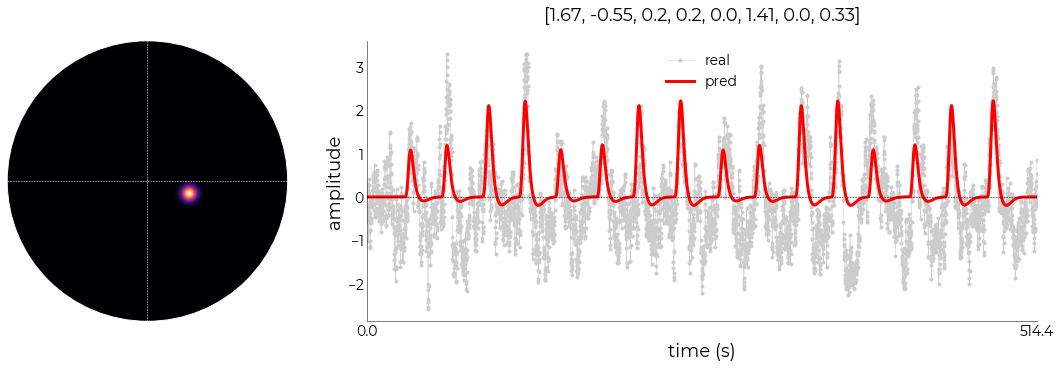

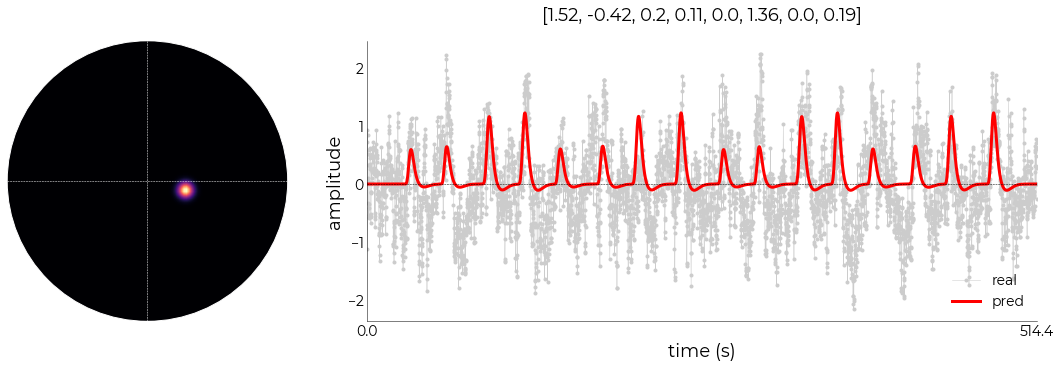

In [126]:
t_s = "sub-003"
_,_,tc_p,pred_p = full_dict[t_s]["lines"]["native"]["ribbon"].plot_vox(
    vox_nr=0,
    model="gauss",
    title="pars"
)

_,_,tc_w,pred_w = full_dict[t_s]["lines"]["native"]["ribbon"].plot_vox(
    vox_nr=-1,
    model="gauss",
    title="pars"
)

---
# Magnitude pial/wm

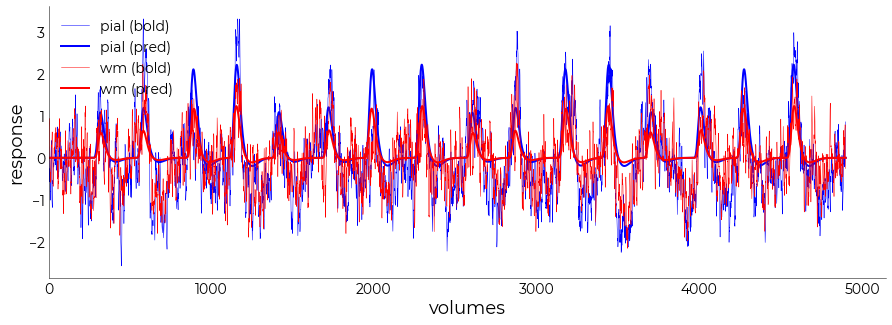

In [132]:
plotting.LazyPlot(
    [tc_p,pred_p,tc_w,pred_w],
    line_width=[0.5,2,0.5,2],
    # markers=[".",None,".",None],
    color=["b","b","r","r"],
    figsize=(15,5),
    x_label="volumes",
    y_label="response",
    labels=[
        "pial (bold)",
        "pial (pred)",
        "wm (bold)",
        "wm (pred)"]
)

In [22]:
# length of HRF window
hrf_length_s = 40
hrf_length_tr = int(hrf_length_s/0.105)

# stimulus duration
stim_dur_s = 1
stim_dur_tr = int(stim_dur_s/0.105)

normalize = False

# csv
fname = opj(fig_dir, "magnitude_profiles.csv")
if not os.path.exists(fname):
    hrf_design = np.zeros(())
    hrfs = []

    for ix,sub in enumerate(subjects):
    # for ix,sub in enumerate(["sub-001"]):

        print(f"Dealing with {sub}")

        sub_hrfs = []
        fit_obj = full_dict[sub]["lines"]["native"]["ribbon"]
        pars = getattr(fit_obj, f"{model}_iter").copy()

        vox_range = np.arange(0,pars.shape[0])
        if sub == "sub-002":
            vox_range = vox_range[:-1]
            
        # elif sub == "sub-003" or sub == "sub-007" or sub == "sub-005":
        #     vox_range = vox_range[:-1]

        # loop through voxel parameters
        for ii in vox_range:
            
            # get the HRF prediction
            _,_,_,hrf = fit_obj.plot_vox(
                vox_nr=ii,
                model=model,
                make_figure=False)
            
            ss = np.sum(hrf)
            is_nan = np.isnan(ss)
            if is_nan:
                print(f" idx {ii} has NaNs")

            # fetch first peak
            hrf = hrf[190:500,...]
            
            # create time axis
            xx = list(np.arange(0,hrf.shape[0])*fit_obj.TR)

            # create dataframe
            df_hrf = pd.DataFrame(hrf, columns=["hrf"])
            df_hrf["subject"],df_hrf["t"],df_hrf["depth"] = sub,xx,ii

            sub_hrfs.append(pd.DataFrame(df_hrf))
        
        # append subject-specific HRFs
        hrfs.append(pd.concat(sub_hrfs))

    # concatenate into single dataframe
    hrf_df = pd.concat(hrfs).set_index(["subject","t","depth"])

    print(f"Writing '{fname}'")
    hrf_df.to_csv(fname)
    print("Done")
else:
    print(f"Reading '{fname}'")
    hrf_df = pd.read_csv(fname).set_index(["subject","t","depth"])
    
hrf_df


Reading '/data1/projects/MicroFunc/Jurjen/programs/project_repos/pRFline/results/magnitude_profiles.csv'


hrf
subject t      depth              
sub-001 0.000  0      5.770731e-17
        0.105  0     -2.308292e-17
        0.210  0      1.154146e-16
        0.315  0      1.269561e-16
        0.420  0     -2.308292e-17
...                            ...
sub-009 32.025 8      1.772201e-03
        32.130 8      1.930729e-03
        32.235 8      2.084196e-03
        32.340 8      2.236930e-03
        32.445 8      2.394511e-03

[14570 rows x 1 columns]

Dealing with sub-001
Dealing with sub-002
Dealing with sub-003
Dealing with sub-005
Dealing with sub-007
Dealing with sub-008
Dealing with sub-009


mag      fwhm        ttp
subject level depth                                   
sub-001 0     0.000000   0.991390  5.138721  12.036048
        1     16.666667  0.993042  5.668612  12.140710
        2     33.333333  1.102227  5.473598  11.931387
        3     50.000000  1.160127  5.576480  12.036048
        4     66.666667  1.337606  5.506747  12.036048

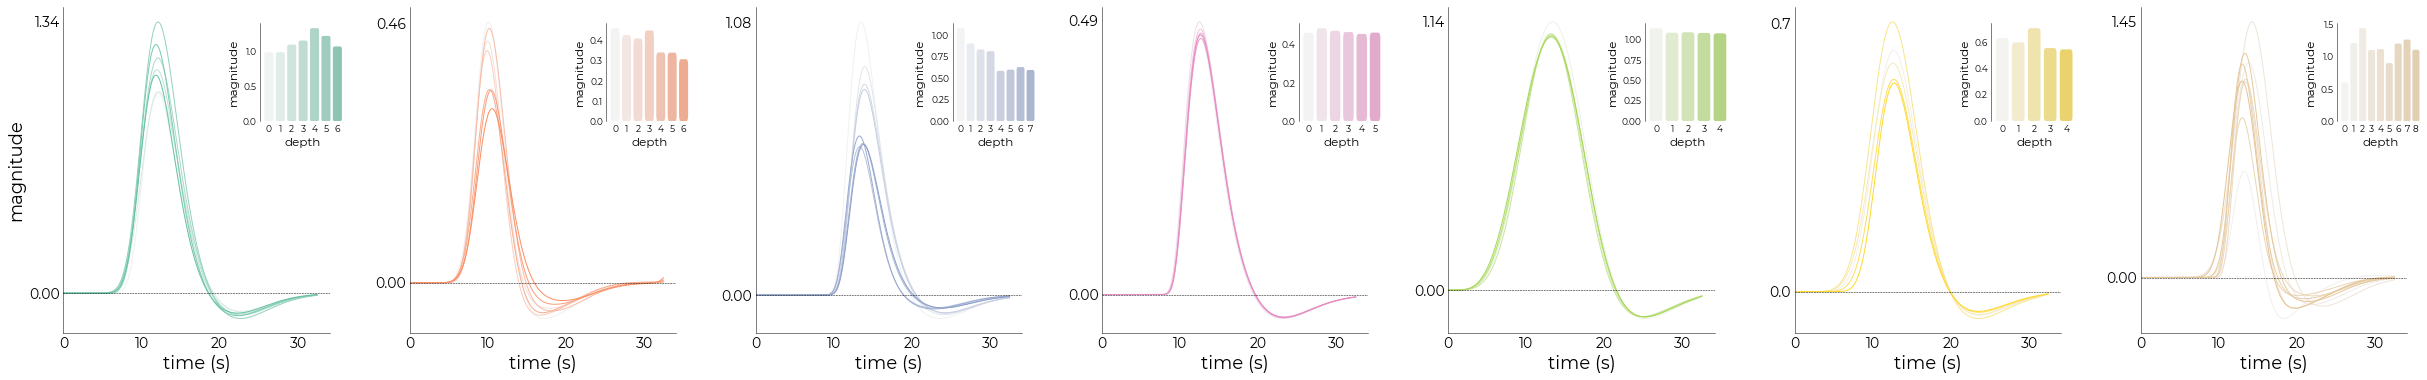

In [54]:
fig,axs = plt.subplots(ncols=len(dict_data),figsize=(6*len(dict_data),6), gridspec_kw={'wspace': 0.3})

plot_mag = True
plot_ttp = True
plot_fwhm = False

df_mag = {}
for ii in ["subject","level","depth","mag","fwhm","ttp"]:
    df_mag[ii] = []

for ix,sub in enumerate(subjects):
    
    # get the pRF-object containing estimates across depth
    if "ribbon" in list(full_dict[sub]["lines"]["native"].keys()):

        print(f"Dealing with {sub}")
        
        fit_obj = full_dict[sub]["lines"]["native"]["ribbon"]

        # get subject-specific HRFs from HRF-dataframe  
        sub_hrf = utils.select_from_df(hrf_df, expression=f"subject = {sub}")

        # parse them into list depending on the number of voxels in estimates
        depths = np.unique(sub_hrf.reset_index()["depth"].values)
        depths_pc = np.arange(0,depths.shape[0])/(depths.shape[0]-1)*100

        hrf_list = []
        for ii in depths:
            dd = utils.select_from_df(sub_hrf, expression=f"depth = {ii}")['hrf'].values
            
            if not np.isnan(dd.sum()):
                hrf_list.append(dd)                

                df_mag["subject"].append(sub)
                df_mag["depth"].append(depths_pc[ii])
                df_mag["level"].append(ii)

        # get subject specific color palette
        colors = sns.color_palette(f"light:{sub_colors.as_hex()[ix]}", len(hrf_list))
        y_ticks = None
        trim_left = False
        if ix == 0:
            if normalize:
                trim_left = True

            y_lbl = "magnitude"
        else:
            y_lbl = None

        # create time axis
        time_axis = list(np.arange(0,hrf_list[0].shape[0])*fit_obj.TR)

        # plot
        y_ticks = [0,round(np.amax(np.array(hrf_list)),2)]
        plotting.LazyPlot(
            hrf_list,
            axs=axs[ix],
            xx=time_axis,
            x_label="time (s)",
            y_label=y_lbl,
            cmap=colors,
            # x_lim=[0,25],
            # x_ticks=np.arange(0,30,5),
            y_ticks=y_ticks,
            add_hline=0,
            trim_left=trim_left
        )

        # # add annotation where stim was ON; timings where the same across subjects/depths so doesn't matter which hrf_dm we use here
        # stim_tp = np.where((np.sum(hrf_dm, axis=(0, 1)) != 0))[0]
        # axs[ix].axvspan(time_axis[stim_tp[0]],time_axis[stim_tp[-1]], color="#cccccc", alpha=0.5) #, ymin=0, ymax=0.05)
        
        # add time-to-peak across the ribbon as inset-axis
        tcs = np.array(hrf_list)
        peak_positions = (np.argmax(tcs, axis=1)/tcs.shape[-1])*xx[-1]

        # FWHM
        fwhm_objs = []
        for hrf in hrf_list:
            fwhm_objs.append(fitting.FWHM(time_axis, hrf))

        y_fwhm = np.array([i.fwhm for i in fwhm_objs])
        if plot_mag or plot_ttp or plot_fwhm:
            ax2 = axs[ix].inset_axes([0.75, 0.65, 0.3, 0.3])

        # get magnitudes
        mag = np.array([np.amax(i) for i in hrf_list])

        for ix,(par,var) in enumerate(zip(["mag","fwhm","ttp"],[mag,y_fwhm,peak_positions])):
            for it_ix,it in enumerate(var):
                df_mag[par].append(it)
        
        # decide plot properties depending on which type to put on the inset axis
        if plot_mag:
            plot_ttp = False
            plot_fwhm = False
            y_ax = mag
            ori = "v"
            y_lab = "magnitude"
            x_lab = "depth"

        if plot_ttp:
            plot_fwhm = False
            y_ax = peak_positions
            ori = "h"
            y_lab = "depth"
            x_lab = "time-to-peak (s)"

        if plot_fwhm:
            y_ax = y_fwhm
            ori = "v"
            y_lab = "FWHM"
            x_lab = "depth"            

        plotting.LazyBar(
            x=np.arange(0,len(hrf_list)),
            y=y_ax,
            axs=ax2,
            label_size=9,
            font_size=12,
            palette=colors,
            sns_ori=ori,
            add_labels=True,
            y_label2=y_lab,
            x_label2=x_lab,
            alpha=0.8,
            fancy=True,
            sns_offset=3,
            trim_bottom=True)            

fname = opj(fig_dir, f"sub-all_model-{model}_desc-depth_hrf")
if normalize:
    fname = f"{fname}_norm"

# for ext in ['png','svg']:
#     fig.savefig(
#         f"{fname}.{ext}",
#         # bbox_inches="tight",
#         dpi=300,
#         facecolor="white"
#     )

df_mag = pd.DataFrame(df_mag).set_index(["subject","level","depth"])
df_mag.head()

In [185]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

lm_df = df_mag.reset_index()
lm_df.head()


,subject,level,depth,mag,fwhm,ttp
0,sub-001,0,0.000000,0.991390,5.138721,12.036048
1,sub-001,1,16.666667,0.993042,5.668612,12.140710
2,sub-001,2,33.333333,1.102227,5.473598,11.931387
3,sub-001,3,50.000000,1.160127,5.576480,12.036048
4,sub-001,4,66.666667,1.337606,5.506747,12.036048


In [249]:
md = smf.mixedlm("mag ~ depth", lm_df, groups=lm_df["subject"], re_formula="~depth")

free = sm.regression.mixed_linear_model.MixedLMParams.from_components(
    np.ones(2), np.eye(2)
)

mdf = md.fit(free=free, method=["lbfgs"])
print(mdf.summary())


           Mixed Linear Model Regression Results
Model:              MixedLM   Dependent Variable:   mag     
No. Observations:   47        Method:               REML    
No. Groups:         7         Scale:                0.0132  
Min. group size:    5         Log-Likelihood:       -10.0486
Max. group size:    9         Converged:            Yes     
Mean group size:    6.7                                     
------------------------------------------------------------
                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------
Intercept          0.820    0.130  6.325 0.000  0.566  1.074
depth             -0.001    0.028 -0.019 0.985 -0.055  0.054
Group Var          0.111    1.147                           
Group x depth Cov  0.000    0.000                           
depth Var          0.005                                    



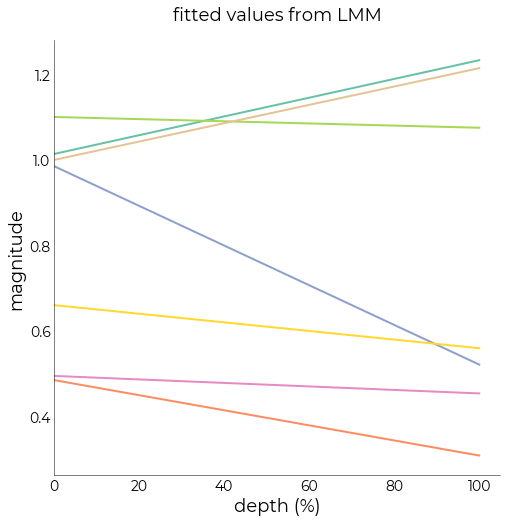

In [252]:
df_pred = pd.DataFrame(mdf.fittedvalues, columns=["pred_value"])
df_pred["subject"] = lm_df["subject"]
df_pred["depth"] = lm_df["depth"]
df_pred

fig,axs = plt.subplots(figsize=(8,8))
for sub_ix,subject in enumerate(subjects):
    data = utils.select_from_df(df_pred, expression=f"subject = {subject}")
    yy = data["pred_value"].values
    depth = data["depth"].values

    plotting.LazyPlot(
        yy,
        xx=depth,
        color=sub_colors[sub_ix],
        line_width=2,
        x_label="depth (%)",
        y_label="magnitude",
        title="fitted values from LMM",
        axs=axs
    )


In [240]:
df_pred

,pred_value,subject,depth
0,0.822589,sub-001,0.000000
1,0.813183,sub-001,16.666667
2,0.803776,sub-001,33.333333
3,0.794370,sub-001,50.000000
4,0.784964,sub-001,66.666667
5,0.775558,sub-001,83.333333
6,0.766151,sub-001,100.000000
7,0.822589,sub-002,0.000000
8,0.813183,sub-002,16.666667
9,0.803776,sub-002,33.333333


In [235]:
resid_df = pd.DataFrame(mdf.resid.values.copy(), columns=["residuals"])
resid_df["subject"] = lm_df["subject"]
resid_df["depth"] = lm_df["depth"]
resid_df.head()


,residuals,subject,depth
0,0.030962,sub-001,0.000000
1,-0.016207,sub-001,16.666667
2,0.044157,sub-001,33.333333
3,0.053235,sub-001,50.000000
4,0.181893,sub-001,66.666667


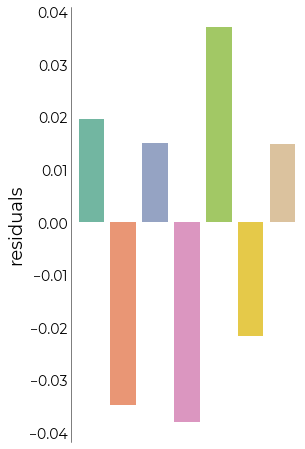

In [253]:
plotting.LazyBar(
    data=resid_df,
    x="subject",
    y="residuals",
    sns_ori="v",
    figsize=(4,8),
    sns_offset=4,
    cmap="Set2",
    y_label2=f"residuals",
    # fancy=True,
    # lim=y_lim,
    trim_bottom=True,
    error=None
)

The random intercept and random slope are only weakly correlated. So next we fit a model in which the two random effects are constrained to be uncorrelated:

In [ ]:
0.001 / (0.098 * 0.003) ** 0.5

0.058321184351980436

In [ ]:
# initialize parameter df
params_depth =  []
params_depth_z =  []

for ix,sub in enumerate(subjects):

    # initialize subject specific parameter df
    sub_hrfs = []

    # get the pRF-object containing estimates across depth
    fit_obj = full_dict[sub]["lines"]["native"]["ribbon"]

    # parse normalization parameters to dataframe
    pars = getattr(fit_obj, f"{model}_iter").copy()
        
    df = prf.SizeResponse.parameters_to_df(pars, model=model)

    # get numerical colums for applying z-score. x/y/baselines will be NaN because they're all zero anyway
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df_z = df[numeric_cols].apply(stats.zscore)
    
    # append depth indexer
    df["subject"] = sub
    df_z["subject"] = sub
    depth = np.arange(0,df_z.shape[0])/(df_z.shape[0]-1)*100
    if subj_obj.get_invert(sub):
        depth = depth[::-1]

    df["depth"] = depth
    df_z["depth"] = depth
    df = df.sort_values("depth")
    df_z = df_z.sort_values("depth")
    params_depth.append(df)
    params_depth_z.append(df_z)
    
params_depth = pd.concat(params_depth)
params_depth = params_depth.set_index(["subject","depth"])

params_depth_z = pd.concat(params_depth_z)
params_depth_z = params_depth_z.set_index(["subject","depth"])

params_depth.head()

x         y  prf_size  prf_ampl  bold_bsl        r2  \
subject depth                                                                   
sub-001 0.000000   2.019043 -1.881439  0.345514  0.068526       0.0  0.200151   
        16.666667  1.979748 -1.923643  0.566493  0.028533       0.0  0.166305   
        33.333333  2.064661 -1.985511  0.506035  0.038265       0.0  0.163659   
        50.000000  2.138572 -1.902191  0.585838  0.030661       0.0  0.194841   
        66.666667  2.269368 -1.865626  0.576369  0.036026       0.0  0.285865   

                        ecc     polar  
subject depth                          
sub-001 0.000000   2.759773 -0.750134  
        16.666667  2.760400 -0.771026  
        33.333333  2.864451 -0.765858  
        50.000000  2.862136 -0.726966  
        66.666667  2.937787 -0.688066

## Check positional stability

Text(0.5, 0.98, 'stability position across depth')

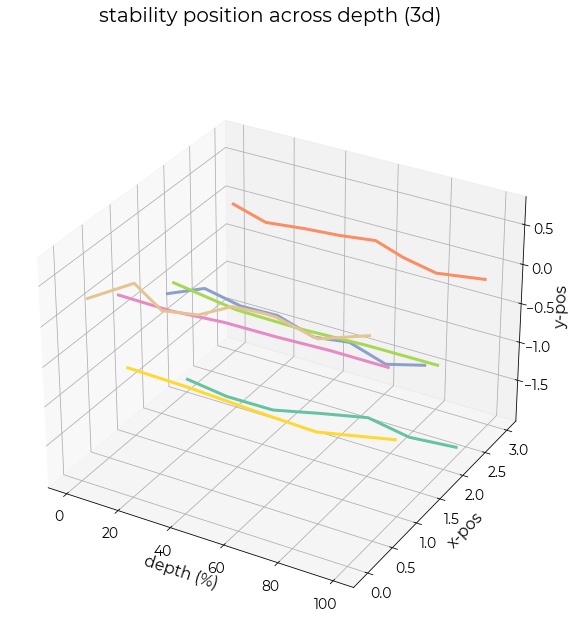

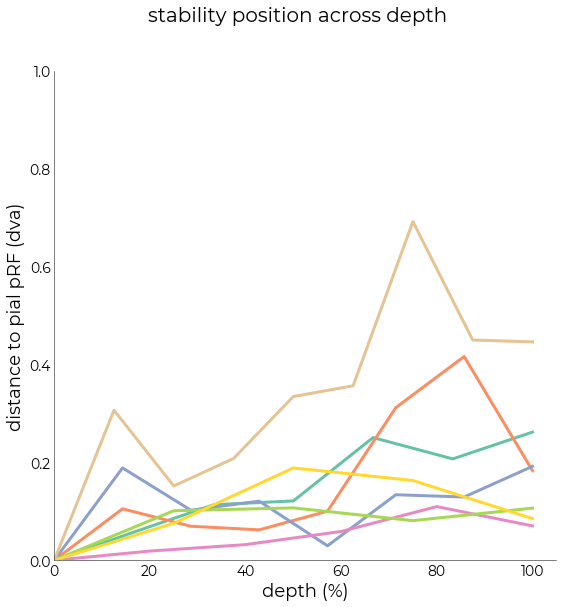

In [ ]:
fig,ax1 = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10,10))

defs = plotting.Defaults()
df_diff = {}
for ii in ["subject","diff0","depth"]:
    
    df_diff[ii] = []

for sub_ix,sub in enumerate(subjects):
    data = utils.select_from_df(params_depth, expression=f"subject = {sub}")
    
    # parse into coordinates
    coordinates = list(zip(data.x, data.y))
    x, y = zip(*coordinates)

    # x axis
    depth_ax = data.reset_index().depth.values
    
    for c_ix,coord in enumerate(coordinates):
        diff = prf.distance_centers(coord,coordinates[0])
        df_diff["subject"].append(sub)
        df_diff["diff0"].append(diff)
        df_diff["depth"].append(depth_ax[c_ix])
    
    ax1.plot(depth_ax, x, y, color=sub_colors[sub_ix], lw=3)

ax1.set_xlabel("depth (%)", fontsize=defs.label_size+2)
ax1.set_ylabel("x-pos", fontsize=defs.label_size+2)
ax1.set_zlabel("y-pos", fontsize=defs.label_size+2)

ax1.tick_params(
    width=defs.tick_width, 
    length=defs.tick_length,
    labelsize=defs.label_size)
fig.suptitle("stability position across depth (3d)", fontsize=defs.font_size+2)

fig,ax2 = plt.subplots(figsize=(9,9))
df_diff = pd.DataFrame(df_diff)

for sub_ix,sub in enumerate(subjects):
    data = utils.select_from_df(df_diff, expression=f"subject = {sub}")

    x_data = data["depth"].values
    y_data = data["diff0"].values

    plotting.LazyPlot(
        y_data,
        xx=x_data,
        axs=ax2,
        color=sub_colors[sub_ix],
        line_width=3,
        x_label="depth (%)",
        y_label="distance to pial pRF (dva)",
        y_lim=[0,1]
    )

fig.suptitle("stability position across depth", fontsize=defs.font_size+2)


In [263]:
utils.select_from_df(params_depth, expression="subject = sub-001").reset_index().depth

0      0.000000
1     16.666667
2     33.333333
3     50.000000
4     66.666667
5     83.333333
6    100.000000
Name: depth, dtype: float64

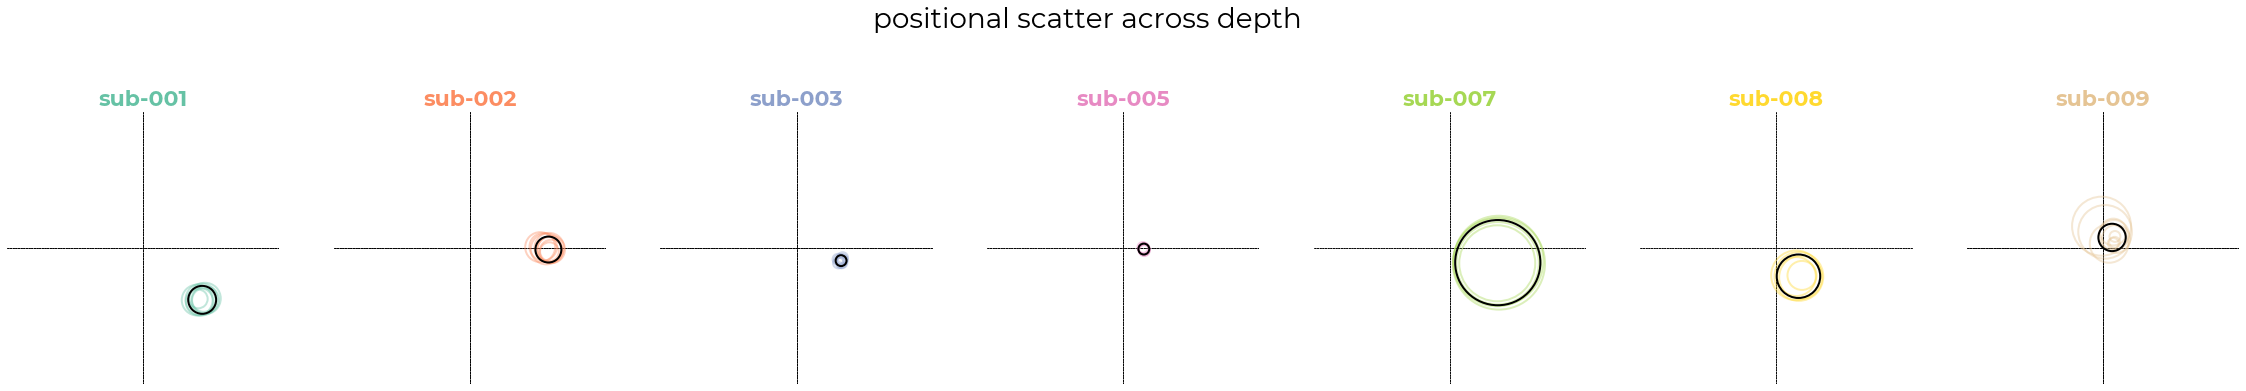

In [288]:
fig = plt.figure(figsize=(40,7))
gs = fig.add_gridspec(ncols=len(process_subjs))

for ix,subject in enumerate(process_subjs):

    rib_o = full_dict[subject]["lines"]["native"]["ribbon"]

    sub_ax = fig.add_subplot(gs[ix])
    depths = utils.select_from_df(
        params_depth, 
        expression=f"subject = {subject}").reset_index().depth.values

    colors = sns.color_palette(f"light:{sub_colors.as_hex()[ix]}", depths.shape[0])
    for d_i,depth in enumerate(depths):
        cm = utils.make_binary_cm(colors[d_i])
        d_par = getattr(rib_o, f"{model}_iter")[d_i,:]
        d_pr = prf.make_prf(
            rib_o.prf_stim,
            mu_x=d_par[0],
            mu_y=d_par[1],
            size=d_par[2]
        )

        plotting.LazyPRF(
            np.zeros_like(d_pr),
            # d_pr,
            [-5,5],
            ax=sub_ax,
            cmap=cm,
            cross_color="k",
            edge_color=None,
            alpha=0.3
        )

        x,y,si = d_par[:3]
        d_line = plt.Circle(
            (x,y),
            si,
            ec=sub_colors[ix],
            fill=False,
            alpha=0.4,
            lw=2)
        sub_ax.add_artist(d_line)

    avg_o = full_dict[subject]["lines"]["native"]["avg"]
    x,y,si = getattr(avg_o, f"{model}_iter")[0,:3]
    sub_line = plt.Circle(
        (x,y),
        si,
        ec="k", #sub_colors[ix],
        fill=False,
        lw=2)

    sub_ax.add_artist(sub_line)
    sub_ax.set_title(subject, fontsize=22, color=sub_colors[ix], fontweight="bold")

fig.suptitle("positional scatter across depth", fontsize=28)
plt.show()

In [302]:
print(rib_o.gauss_iter)
print(tt_p)

[[ 2.16273165 -1.91535471  0.51329957  0.0372316   0.          0.89182175
   0.          0.23094074]]
[[ 2.28841706 -2.05820462  0.67135107  0.02620009  0.          0.30139958]]


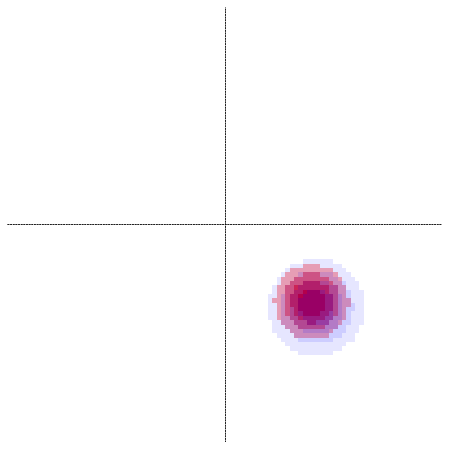

In [300]:
tt = "/data1/projects/MicroFunc/Jurjen/projects/VE-pRF/derivatives/prf/sub-001/ses-2_backup/sub-001_ses-2_task-pRF_run-avg_vox-avg_model-gauss_stage-iter_desc-prf_params.pkl"
tt_p = prf.read_par_file(tt)

rib_o = full_dict["sub-001"]["lines"]["native"]["avg"]
orig_prf = prf.make_prf(
    rib_o.prf_stim,
    mu_x=rib_o.gauss_iter[0,0],
    mu_y=rib_o.gauss_iter[0,1],
    size=rib_o.gauss_iter[0,2])

fig,axs = plt.subplots(figsize=(8,8))
plotting.LazyPRF(
    orig_prf,
    [-5,5],
    cross_color="k",
    edge_color=None,
    cmap=utils.make_binary_cm("red"),
    ax=axs
)
plotting.LazyPRF(
    orig_prf,
    [-5,5],
    cross_color="k",
    edge_color=None,
    cmap=utils.make_binary_cm("red"),
    ax=axs,
    alpha=0.4
)

scr_prf = prf.make_prf(
    rib_o.prf_stim,
    mu_x=tt_p[0,0],
    mu_y=tt_p[0,1],
    size=tt_p[0,2])

plotting.LazyPRF(
    scr_prf,
    [-5,5],
    cross_color="k",
    edge_color=None,
    cmap=utils.make_binary_cm("blue"),
    ax=axs,
    alpha=0.4
)

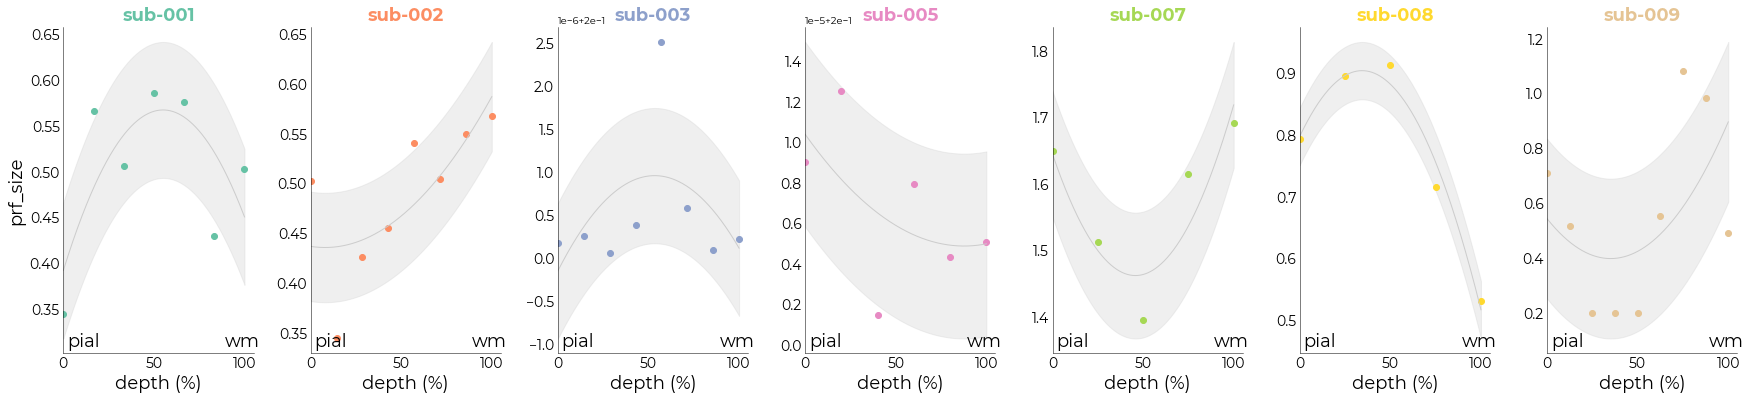

In [ ]:
fit_order = 2

# initialize figure
fig = plt.figure(figsize=(30,6))
gs = fig.add_gridspec(ncols=len(subjects), wspace=0.3)

par = "prf_size"
for sub_ix,sub in enumerate(subjects):
    ax = fig.add_subplot(gs[sub_ix])

    # get subject-specific dataframe
    data = utils.select_from_df(params_depth, expression=f"subject = {sub}")

    # and depths
    depths = data.reset_index()["depth"].values

    for ix,dep in enumerate(depths):
        ax.plot(
            dep,
            data[par].iloc[ix], 
            "o", 
            color=sub_colors[sub_ix])

    yy = data[par].values
    cf = fitting.CurveFitter(
        yy, 
        x=np.linspace(0,100,yy.shape[0]),
        order=fit_order, 
        verbose=False)

    # plot fit
    if sub_ix == 0:
        y_lbl = par
    else:
        y_lbl = None

    pl = plotting.LazyPlot(
        cf.y_pred_upsampled,
        xx=cf.x_pred_upsampled,
        axs=ax,
        error=cf.ci_upsampled,
        color="#cccccc",
        x_label="depth (%)",
        x_ticks=[0,50,100],
        # y_lim=[-1,2],
        y_label=y_lbl)

    # pial
    ax.annotate(
        "pial", 
        (0.02,0.02), 
        fontsize=pl.font_size,
        xycoords="axes fraction")

    # wm
    ax.annotate(
        "wm", 
        (0.85,0.02), 
        fontsize=pl.font_size,
        xycoords="axes fraction")

    ax.set_title(sub, fontsize=18, color=sub_colors[sub_ix], fontweight="bold")

fname = opj(fig_dir, f"sub-all_model-{model}_desc-depth_{par}")
# for ext in ['png','svg']:
#     fig.savefig(
#         f"{fname}.{ext}",
#         bbox_inches="tight",
#         dpi=300,
#         facecolor="white"
#     )    

r2: AIC (lin) = -4.54, AIC (2nd) = -4.52
prf_size: AIC (lin) = 0.79, AIC (2nd) = 1.68
B: AIC (lin) = 3.88, AIC (2nd) = 5.86
D: AIC (lin) = 3.97, AIC (2nd) = 3.48


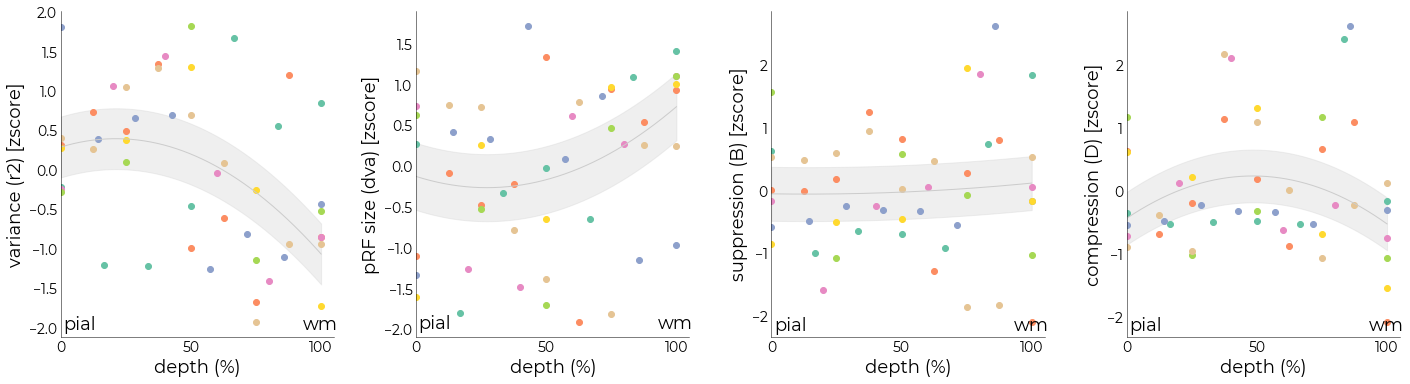

In [ ]:
# make list of parameters to include; should strings that are present as column names in dataframe above
include = ["r2","prf_size","B","D"]
fit_order = 2

# initialize figure
fig = plt.figure(figsize=(24,6))
gs = fig.add_gridspec(ncols=len(include), wspace=0.3)

aic_df = {}
aic_df["model"],aic_df["code"],aic_df["aic"],aic_df["par"] = [],[],[],[]

# loop through parameters
for par_ix,par in enumerate(include):
    
    # add axis to plot
    ax = fig.add_subplot(gs[par_ix])

    # prettify axis labels
    if par == "prf_size":
        x_label = "pRF size (dva) [zscore]"
    elif par == "A":
        x_label = "activation amplitude (A) [zscore]"
    elif par == "B":
        x_label = "suppression (B) [zscore]"
    elif par == "C":
        x_label = "normalization amplitude (C) [zscore]"
    elif par == "D":
        x_label = "compression (D) [zscore]"
    elif par == "r2":
        x_label = "variance (r2) [zscore]"
    else:
        x_label = f"{par} [zscore]"

    # for sub_ix,sub in enumerate(["sub-001","sub-002","sub-003","sub-007","sub-008"]):
    for sub_ix,sub in enumerate(subjects):

        # get subject-specific dataframe
        data = utils.select_from_df(params_depth, expression=f"subject = {sub}")

        # and depths
        depths = data.reset_index()["depth"].values

        for ix,dep in enumerate(depths):
            ax.plot(
                dep,
                data[par].iloc[ix], 
                "o", 
                color=sub_colors[sub_ix])

    # throw all subjects in CurveFitter
    if not isinstance(fit_order, int):
        if len(fit_order) != len(subjects):
            raise ValueError(f"Expected a list of length {len(include)} for fit orders, not {len(fit_order)}. Please specify an integer representing the fit order for all elements in {include} or a list of fit orders for each parameter")

        order = fit_order[par_ix]
    else:
        order = fit_order

    yy = params_depth.sort_values(['depth','subject'])[par].values
    
    # run linear model for AIC comparison
    cf_lin = fitting.CurveFitter(
        yy, 
        x=np.linspace(0,100,yy.shape[0]),
        order=1, 
        verbose=False)

    add_par = par
    if par == "prf_size":
        add_par = "size"

    aic_df["code"].append(0)
    aic_df["model"].append("linear")
    aic_df["aic"].append(cf_lin.result.aic)
    aic_df["par"].append(add_par)

    cf = fitting.CurveFitter(
        yy, 
        x=np.linspace(0,100,yy.shape[0]),
        order=order, 
        verbose=False)

    aic_df["code"].append(1)
    aic_df["model"].append("2nd order")
    aic_df["aic"].append(cf.result.aic)
    aic_df["par"].append(add_par)


    print(f"{par}: AIC (lin) = {round(cf_lin.result.aic,2)}, AIC (2nd) = {round(cf.result.aic,2)}")

    # plot fit
    pl = plotting.LazyPlot(
        cf.y_pred_upsampled,
        xx=cf.x_pred_upsampled,
        axs=ax,
        error=cf.ci_upsampled,
        color="#cccccc",
        x_label="depth (%)",
        x_ticks=[0,50,100],
        y_label=x_label)

    # pial
    ax.annotate(
        "pial", 
        (0.02,0.02), 
        fontsize=pl.font_size,
        xycoords="axes fraction")

    # wm
    ax.annotate(
        "wm", 
        (0.85,0.02), 
        fontsize=pl.font_size,
        xycoords="axes fraction")

aic_df = pd.DataFrame(aic_df)
fname = opj(fig_dir, f"sub-all_model-{model}_desc-depth_pars_scatter3")
for ext in ['png','svg']:
    fig.savefig(
        f"{fname}.{ext}",
        bbox_inches="tight",
        dpi=300,
        facecolor="white"
    )

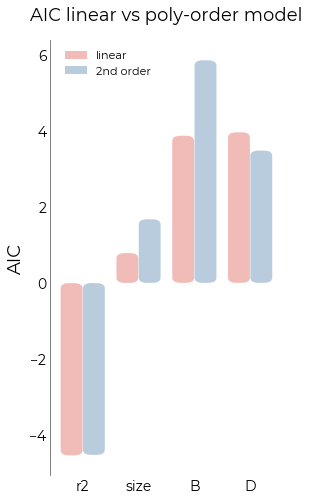

In [ ]:
fig,axs = plt.subplots(figsize=(4,8))

plotting.LazyBar(
    data=aic_df,
    x="par",
    y="aic",
    hue="model",
    sns_ori="v",
    sns_offset=5,
    axs=axs,
    add_labels=True, 
    y_label2="AIC",
    fancy=True,
    fancy_aspect=0.9,
    trim_bottom=True,
    error=None,
    add_legend=True,
    cmap="Pastel1",
    title2="AIC linear vs poly-order model"
)

fname = opj(fig_dir, f"sub-all_model-{model}_desc-depth_aic")
for ext in ['png','svg']:
    fig.savefig(
        f"{fname}.{ext}",
        bbox_inches="tight",
        dpi=300,
        facecolor="white"
    )

In [ ]:
data

x   y  prf_size  prf_ampl  bold_bsl  neur_bsl  surr_ampl  \
subject depth                                                              
sub-008 0.0   NaN NaN -1.597552  0.328125       NaN -0.849508   0.511573   
        25.0  NaN NaN  0.258185 -0.416644       NaN -0.492242  -0.144971   
        50.0  NaN NaN -0.643662  1.091903       NaN -0.444110   1.414735   
        75.0  NaN NaN  0.973300  0.727759       NaN  1.952211  -0.139264   
        100.0 NaN NaN  1.009729 -1.731143       NaN -0.166352  -1.642074   

               surr_size  surr_bsl         A         B         C         D  \
subject depth                                                                
sub-008 0.0    -1.642459       NaN  0.328125 -0.849508  0.511573  0.630048   
        25.0    0.991569       NaN -0.416644 -0.492242 -0.144971  0.232586   
        50.0    1.051592       NaN  1.091903 -0.444110  1.414735  1.332119   
        75.0    0.057519       NaN  0.727759  1.952211 -0.139264 -0.669631   
        100.0  -0.458220       NaN -1.731143 -0.166352 -1.642074 -1.525122   

               ratio (B/D)        r2  size ratio  suppression index  ecc  \
subject depth                                                              
sub-008 0.0      -0.622082  0.280643    0.403890           0.520987  NaN   
        25.0     -0.547010  0.387475    0.388923           0.378869  NaN   
        50.0     -0.688754  1.313339    1.449324           1.327477  NaN   
        75.0     -0.099089 -0.254808   -0.932020          -0.699948  NaN   
        100.0     1.956935 -1.726649   -1.310118          -1.527386  NaN   

               polar  
subject depth         
sub-008 0.0      NaN  
        25.0     NaN  
        50.0     NaN  
        75.0     NaN  
        100.0    NaN

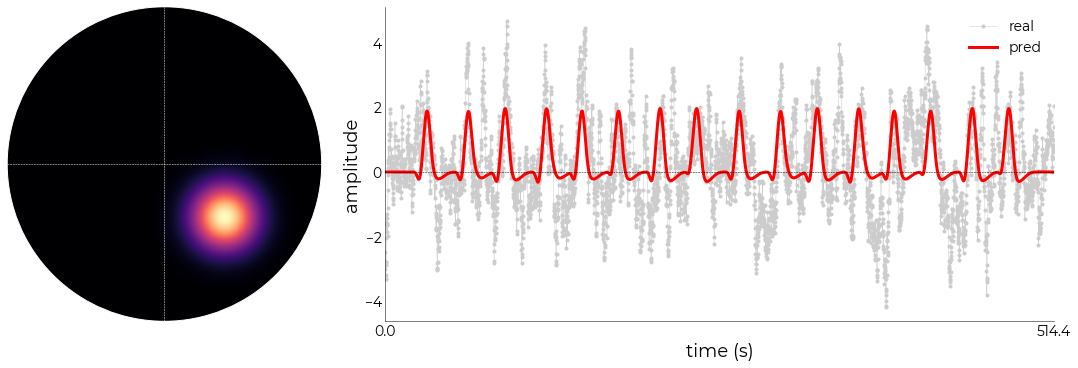

In [ ]:
_,_,tc,_ = full_dict["sub-001"]['lines']['native']['ribbon'].plot_vox(
    vox_nr=1,
    model=model,
    stage='iter'
)

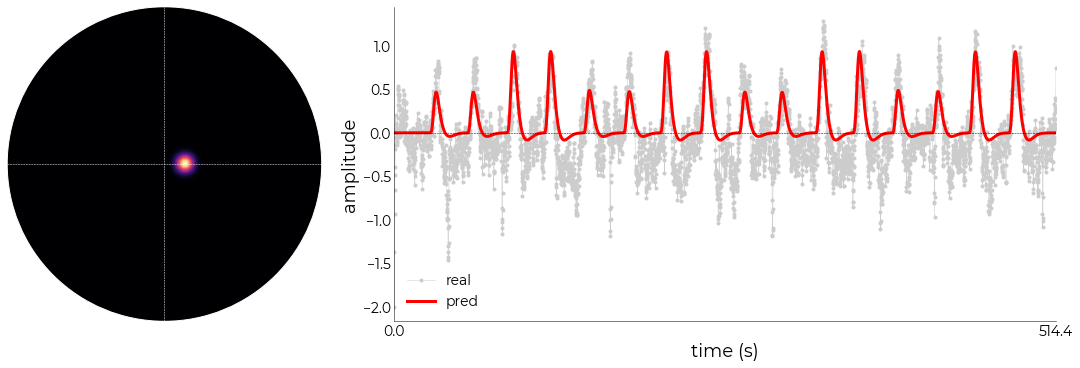

In [224]:
_,_,tc,_ = full_dict["sub-005"]['lines']['native']['avg'].plot_vox(
    model=model,
    stage='iter'
)

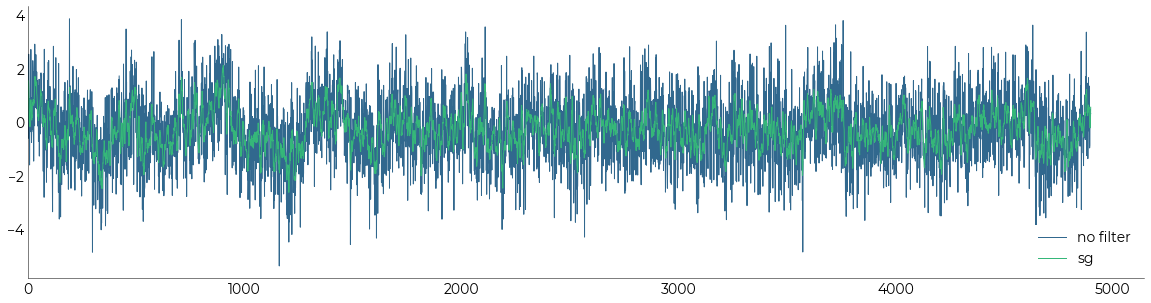

In [ ]:
from linescanning import preproc
tc_sg = preproc.lowpass_savgol(tc, window_length=13, polyorder=3)

plotting.LazyPlot(
    [tc,tc_sg],
    labels=["no filter","sg"],
    figsize=(20,5)
)

---
# Linear mixed modeling of depth

In [ ]:
full_dict[sub]['wb'][0].norm_iter.shape

(1, 10)